In [1]:
### Load data IMU CSV dan dibersihkan tahap 1###
import pandas as pd

# Baca data CSV
df = pd.read_excel('imu_data_baru.xlsx')

# 1. Tampilkan info umum data
print(df.info())
print(df.head())

# 2. Buang kolom yang tidak relevan (ganti 'kolom_tidak_dipakai' sesuai kebutuhan)
# df.drop(columns=['kolom_tidak_dipakai'], inplace=True)

# 3. Tangani nilai hilang (missing values)
# Contoh: isi dengan median, hapus, atau metode lain
# df = df.dropna()  # jika ingin langsung membuang baris yang ada NaN
# df['kolom_angka'] = df['kolom_angka'].fillna(df['kolom_angka'].median())

# 4. Bersihkan data string, misalnya hapus spasi putih atau ubah ke lowercase
# df['nama_kolom'] = df['nama_kolom'].str.strip().str.lower()

# 5. Ubah tipe data jika perlu
# df['tanggal'] = pd.to_datetime(df['tanggal'], errors='coerce')
# df['angka'] = pd.to_numeric(df['angka'], errors='coerce')

# 6. Buang duplikat
df.drop_duplicates(inplace=True)

# 7. Simpan data yang sudah dibersihkan
df.to_csv('data_imu_clean.csv', index=False)
print("Data berhasil dibersihkan dan disimpan sebagai 'data_imu_clean.csv'")


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1913 entries, 0 to 1912
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ax      1913 non-null   object 
 1   ay      1913 non-null   object 
 2   az      1913 non-null   float64
 3   gx      1913 non-null   float64
 4   gy      1913 non-null   float64
 5   gz      1913 non-null   float64
 6   label   1913 non-null   int64  
dtypes: float64(4), int64(1), object(2)
memory usage: 104.7+ KB
None
         ax        ay        az        gx        gy        gz  label
0 -0.078629 -0.072346  0.328973 -0.030680 -0.117878 -0.096649      1
1  0.027023  0.135176  0.212524 -0.082713  0.010752  0.040630      1
2  0.127246   0.04087 -0.545340 -0.049066  0.074546  0.170800      1
3  0.009516  0.053802 -0.926224 -0.057500  0.105462 -0.438776      1
4 -0.006466  0.918721  0.430050 -0.146734  0.144089  0.588326      1
Data berhasil dibersihkan dan disimpan sebagai 'data_imu_clean.csv'


In [2]:
### Pembersihan data tahap 2 
import pandas as pd

# Load CSV dan paksa semua nilai ke bentuk numerik
df = pd.read_csv("data_imu_clean.csv")

# Buang spasi putih di awal/akhir sel
df = df.applymap(lambda x: str(x).strip() if isinstance(x, str) else x)

# Konversi semua kolom ke numeric jika bisa, dan paksa NaN jika gagal
for col in df.columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Drop baris dengan NaN akibat parsing gagal
df.dropna(inplace=True)
df.to_csv("data_imu_oke.csv", index=False)
print(" File bersih disimpan sebagai: data_imu_oke.csv")

print(" Data berhasil dibersihkan dari nilai yang tidak bisa dikonversi.")

 File bersih disimpan sebagai: data_imu_oke.csv
 Data berhasil dibersihkan dari nilai yang tidak bisa dikonversi.


/var/folders/lt/2mkl6ry53ll9fdk2br6skfgw0000gn/T/ipykernel_6444/1157609479.py:8: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: str(x).strip() if isinstance(x, str) else x)


Label yang ditemukan: [ 1  0 10]


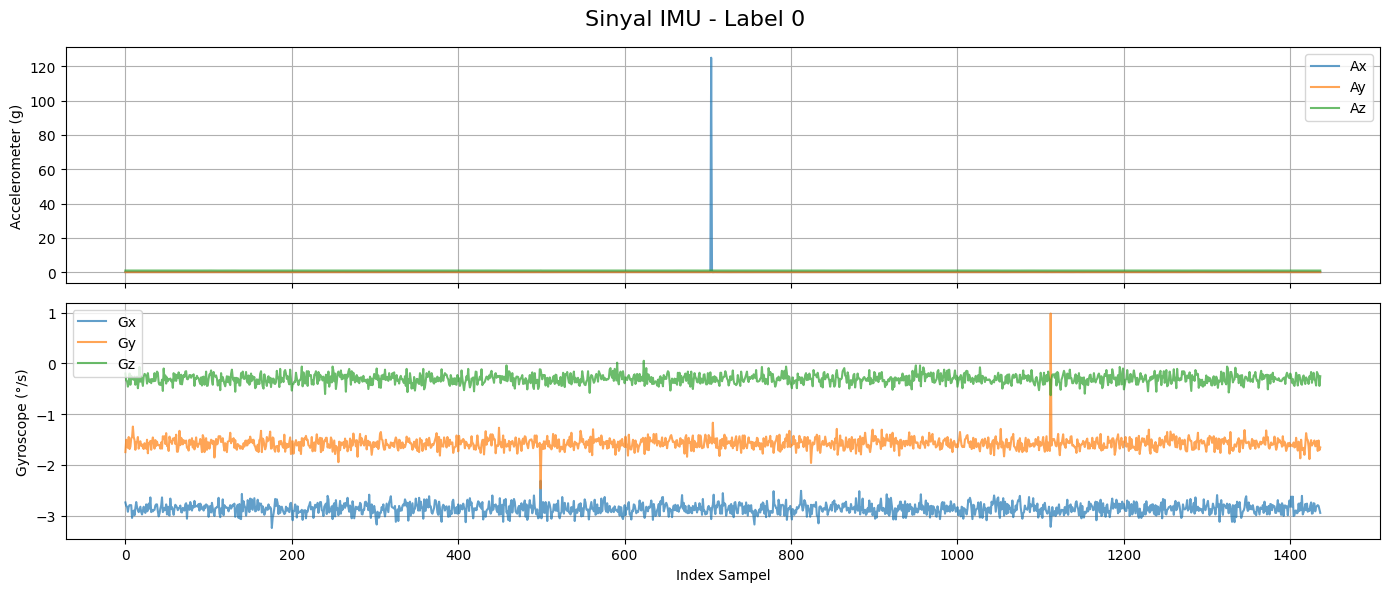

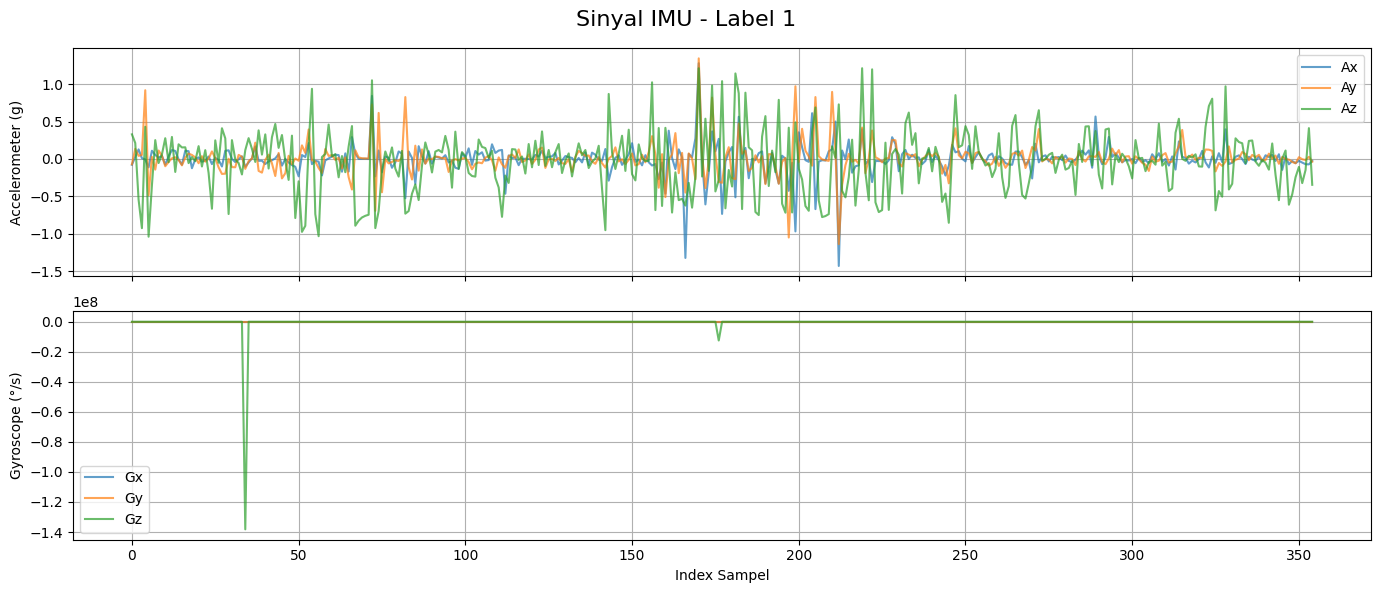

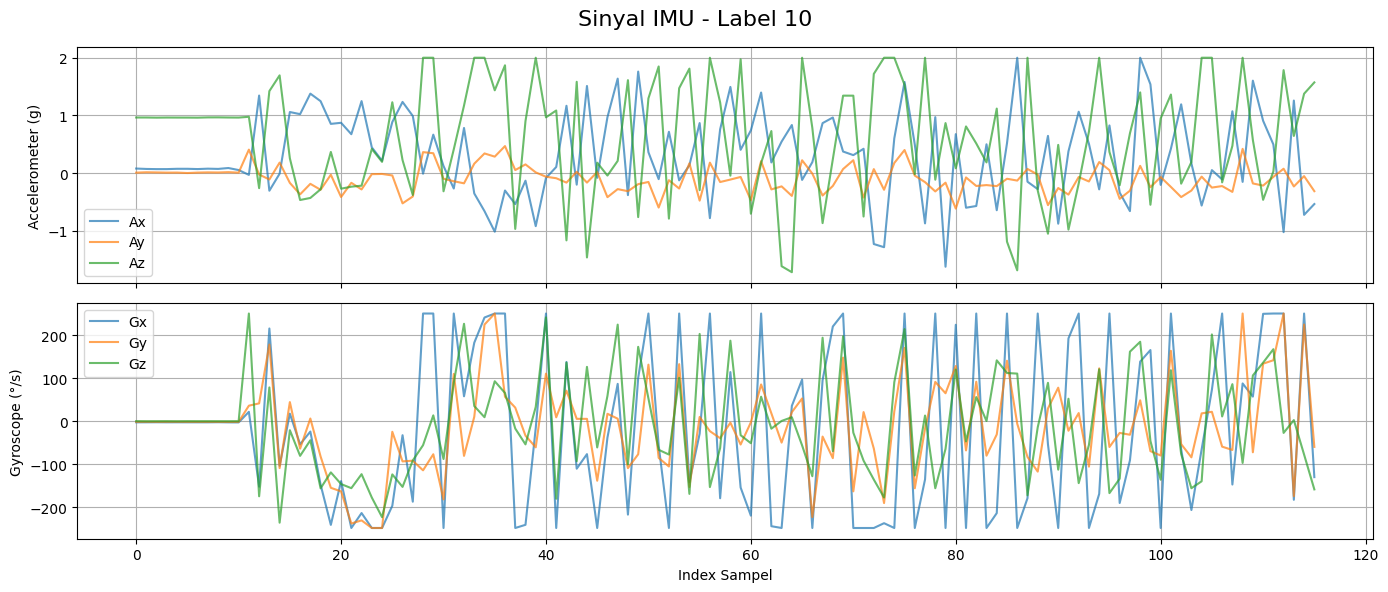

In [3]:
### Visualisasi data IMU
import pandas as pd
import matplotlib.pyplot as plt

# Baca file CSV
df = pd.read_csv("data_imu_oke.csv")

# Tampilkan label unik
print("Label yang ditemukan:", df['label'].unique())

# Loop visualisasi per label
for label in sorted(df['label'].unique()):
    subset = df[df['label'] == label].reset_index(drop=True)

    fig, axs = plt.subplots(2, 1, figsize=(14, 6), sharex=True)
    fig.suptitle(f'Sinyal IMU - Label {label}', fontsize=16)

    # Akselerometer
    axs[0].plot(subset['ax'], label='Ax', alpha=0.7)
    axs[0].plot(subset['ay'], label='Ay', alpha=0.7)
    axs[0].plot(subset['az'], label='Az', alpha=0.7)
    axs[0].set_ylabel('Accelerometer (g)')
    axs[0].legend()
    axs[0].grid(True)

    # Gyroscope
    axs[1].plot(subset['gx'], label='Gx', alpha=0.7)
    axs[1].plot(subset['gy'], label='Gy', alpha=0.7)
    axs[1].plot(subset['gz'], label='Gz', alpha=0.7)
    axs[1].set_ylabel('Gyroscope (°/s)')
    axs[1].set_xlabel('Index Sampel')
    axs[1].legend()
    axs[1].grid(True)

    plt.tight_layout()
    plt.show()


In [4]:
subset = subset.iloc[:300]  # atau nilai yang sesuai


In [5]:
axs[0].plot(subset['ax'], label='Ax', color='red')
axs[0].plot(subset['ay'], label='Ay', color='green')
axs[0].plot(subset['az'], label='Az', color='blue')


In [6]:
#### Ekstraksi Fitur per window IMU
import pandas as pd
import numpy as np
from collections import Counter

def extract_features_from_imu(
    filepath,
    fs=50,
    window_duration=2,
    stride_ratio=1.0,
    axis_cols=['ax', 'ay', 'az', 'gx', 'gy', 'gz'],
    label_col='label'
):
    df = pd.read_csv(filepath)
    df = df.dropna()
    
    # Konversi numerik
    for col in axis_cols + [label_col]:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    df = df.dropna(subset=axis_cols + [label_col])

    window_size = int(fs * window_duration)
    stride = int(window_size * stride_ratio)
    features = []

    for start in range(0, len(df) - window_size + 1, stride):
        end = start + window_size
        window = df.iloc[start:end]
        row = {}

        for axis in axis_cols:
            signal = window[axis]
            row[f'{axis}_mean'] = signal.mean()
            row[f'{axis}_std'] = signal.std()
            row[f'{axis}_max'] = signal.max()
            row[f'{axis}_min'] = signal.min()
            row[f'{axis}_range'] = signal.max() - signal.min()
            row[f'{axis}_rms'] = np.sqrt(np.mean(signal**2))
            row[f'{axis}_energy'] = np.sum(signal**2)
            row[f'{axis}_mad'] = np.mean(np.abs(signal - signal.mean()))

        # Label mayoritas
        dominant_label = Counter(window[label_col]).most_common(1)[0][0]
        row['label'] = dominant_label
        features.append(row)

    return pd.DataFrame(features)


In [7]:
### Jalankan fungsi Ekstraksi Fitur per Window
features_df = extract_features_from_imu(
    filepath='data_imu_oke.csv',
    fs=50,
    window_duration=2,
    stride_ratio=0.5  # 50% overlap
)

print(features_df.head())


    ax_mean    ax_std    ax_max    ax_min  ax_range    ax_rms  ax_energy  \
0 -0.001800  0.138879  0.842776 -0.526552  1.369328  0.138194   1.909761   
1  0.002575  0.148710  0.842776 -0.526552  1.369328  0.147987   2.190002   
2 -0.024013  0.280006  1.279719 -1.324310  2.604029  0.279635   7.819568   
3 -0.028147  0.336722  1.279719 -1.431792  2.711511  0.336215  11.304044   
4  0.012643  0.217772  0.611525 -1.431792  2.043317  0.217049   4.711021   

     ax_mad   ay_mean    ay_std  ...    gy_mad       gz_mean        gz_std  \
0  0.083416 -0.005782  0.215804  ...  0.146163 -1.382287e+06  1.382287e+07   
1  0.088377 -0.001498  0.182067  ...  0.104707  2.983396e-04  3.330588e-01   
2  0.156977 -0.007355  0.262847  ...  0.084020 -1.248698e+05  1.248698e+06   
3  0.197329  0.017644  0.326532  ...  0.057220 -1.248698e+05  1.248698e+06   
4  0.114975  0.029988  0.209088  ...  0.026765  6.558492e-03  9.310126e-02   

     gz_max        gz_min      gz_range        gz_rms     gz_energy  \
0  

 Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         9
           1       0.67      1.00      0.80         2
          10       0.00      0.00      0.00         1

    accuracy                           0.92        12
   macro avg       0.56      0.67      0.60        12
weighted avg       0.86      0.92      0.88        12



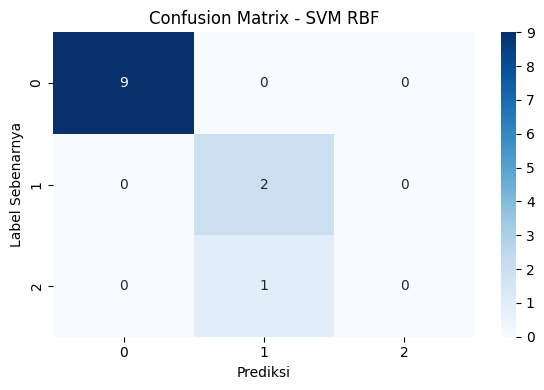

In [8]:
### Proses SVM _ RBF_ ConMatrix
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Pisahkan fitur dan label
X = features_df.drop(columns=['label'])
y = features_df['label']

# Normalisasi
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Pecah data (tanpa stratify kalau jumlah label tidak merata)
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.3, random_state=42
)

# Latih model SVM dengan RBF kernel
model = SVC(kernel='rbf', C=1.0, gamma='scale')
model.fit(X_train, y_train)

# Prediksi
y_pred = model.predict(X_test)

# Evaluasi
print(" Classification Report:")
print(classification_report(y_test, y_pred, zero_division=0))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - SVM RBF")
plt.xlabel("Prediksi")
plt.ylabel("Label Sebenarnya")
plt.tight_layout()
plt.show()


In [9]:
import time
import numpy as np
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, StratifiedKFold, LeaveOneOut
from sklearn.metrics import make_scorer, accuracy_score, f1_score

def run_cv_pipeline(X, y, model_desc="SVM RBF", C=1.0, gamma='scale', cv_strategy=None):
    from sklearn.model_selection import cross_validate

    if cv_strategy is None:
        if len(y) < 10:
            cv_strategy = LeaveOneOut()
            cv_name = "Leave-One-Out"
        else:
            cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
            cv_name = "Stratified 5-Fold"
    else:
        cv_name = str(cv_strategy)

    clf = SVC(kernel='rbf', C=C, gamma=gamma)

    scoring = {
        'accuracy': make_scorer(accuracy_score),
        'f1_macro': make_scorer(f1_score, average='macro')
    }

    start = time.time()
    scores = cross_validate(clf, X, y, cv=cv_strategy, scoring=scoring, return_train_score=False)
    end = time.time()

    print(f" Model: {model_desc}")
    print(f" Evaluasi: {cv_name}")
    print(f" Akurasi Rerata: {scores['test_accuracy'].mean():.4f} ± {scores['test_accuracy'].std():.4f}")
    print(f" F1-score Macro: {scores['test_f1_macro'].mean():.4f}")
    print(f" Durasi Evaluasi: {end - start:.2f} detik")

    return scores


In [10]:
X_all = X_scaled  # dari features_df
scores_all = run_cv_pipeline(X_all, y, model_desc="SVM Semua Fitur")


 Model: SVM Semua Fitur
 Evaluasi: Stratified 5-Fold
 Akurasi Rerata: 0.8679 ± 0.1204
 F1-score Macro: 0.7500
 Durasi Evaluasi: 0.03 detik


/Users/verykurniabakti/envs/visenv/lib/python3.13/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


In [11]:
# 1. Cek ukuran total dan jumlah kolom
print(" Ukuran dataset:", features_df.shape)

# 2. Distribusi label
print(" Distribusi label:")
print(features_df['label'].value_counts())

# 3. Apakah ada nilai NaN?
print(" Jumlah nilai kosong:", features_df.isnull().sum().sum())

# 4. Jumlah fitur numerik (exclude label)
print(" Jumlah fitur:", features_df.drop(columns=['label']).shape[1])


 Ukuran dataset: (37, 49)
 Distribusi label:
label
0     28
1      7
10     2
Name: count, dtype: int64
 Jumlah nilai kosong: 0
 Jumlah fitur: 48


In [12]:
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
import numpy as np

def fitness_function(params, X, y, cv=3):
    from sklearn.svm import SVC
    from sklearn.model_selection import cross_val_score

    results = []
    for C, gamma in params:
        clf = SVC(C=C, gamma=gamma, kernel='rbf')
        score = cross_val_score(clf, X, y, cv=cv).mean()
        results.append(-score)  # PSO minimize, so use negative
    return np.array(results)


def run_pso(X, y, n_particles=20, n_iter=50, cv=3):
    import pyswarms as ps

    # Boundaries for C and gamma
    bounds = ([1e-3, 1e-5], [100, 10])

    optimizer = ps.single.GlobalBestPSO(
        n_particles=n_particles,
        dimensions=2,
        options={'c1': 0.5, 'c2': 0.3, 'w': 0.9},
        bounds=bounds
    )

    best_cost, best_pos = optimizer.optimize(
        fitness_function, n_iter, X=X, y=y, cv=cv
    )

    C_opt, gamma_opt = best_pos
    print(f" Optimal C: {C_opt:.4f}, gamma: {gamma_opt:.6f}")
    return C_opt, gamma_opt


In [13]:
features_df = extract_features_from_imu(
    filepath='data_imu_oke.csv',
    fs=50,
    window_duration=2,
    stride_ratio=0.5  # 50% overlap
)

print(features_df.head())

    ax_mean    ax_std    ax_max    ax_min  ax_range    ax_rms  ax_energy  \
0 -0.001800  0.138879  0.842776 -0.526552  1.369328  0.138194   1.909761   
1  0.002575  0.148710  0.842776 -0.526552  1.369328  0.147987   2.190002   
2 -0.024013  0.280006  1.279719 -1.324310  2.604029  0.279635   7.819568   
3 -0.028147  0.336722  1.279719 -1.431792  2.711511  0.336215  11.304044   
4  0.012643  0.217772  0.611525 -1.431792  2.043317  0.217049   4.711021   

     ax_mad   ay_mean    ay_std  ...    gy_mad       gz_mean        gz_std  \
0  0.083416 -0.005782  0.215804  ...  0.146163 -1.382287e+06  1.382287e+07   
1  0.088377 -0.001498  0.182067  ...  0.104707  2.983396e-04  3.330588e-01   
2  0.156977 -0.007355  0.262847  ...  0.084020 -1.248698e+05  1.248698e+06   
3  0.197329  0.017644  0.326532  ...  0.057220 -1.248698e+05  1.248698e+06   
4  0.114975  0.029988  0.209088  ...  0.026765  6.558492e-03  9.310126e-02   

     gz_max        gz_min      gz_range        gz_rms     gz_energy  \
0  

In [14]:
### Mulai PSO
import numpy as np
import pandas as pd
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

def fitness_function(params, X, y, cv=3):
    results = []
    for C, gamma in params:
        model = SVC(C=C, gamma=gamma, kernel='rbf')
        scores = cross_val_score(model, X, y, cv=cv)
        results.append(-scores.mean())  # PSO minimizes
    return np.array(results)

def run_svm_pso_pipeline(features_df, n_particles=20, n_iter=50, cv=3, save_csv=False, csv_path="svm_pso_log.csv"):
    import pyswarms as ps

    # Step 1: Prepare features and labels
    X = features_df.drop(columns=['label']).values
    y = features_df['label'].values
    X_scaled = StandardScaler().fit_transform(X)

    # Step 2: PSO optimization
    bounds = ([1e-3, 1e-5], [100, 10])  # lower, upper for C and gamma
    optimizer = ps.single.GlobalBestPSO(
        n_particles=n_particles,
        dimensions=2,
        options={'c1': 0.5, 'c2': 0.3, 'w': 0.9},
        bounds=bounds
    )
    print(" Menjalankan PSO untuk optimasi hyperparameter SVM...")
    best_cost, best_pos = optimizer.optimize(
        fitness_function, n_iter, X=X_scaled, y=y, cv=cv
    )
    C_opt, gamma_opt = best_pos
    print(f" Optimal C: {C_opt:.4f}, gamma: {gamma_opt:.6f}")

    # Step 3: Evaluate model
    clf = SVC(kernel='rbf', C=C_opt, gamma=gamma_opt)
    skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42)

    all_scores = []
    all_reports = []
    all_conf_matrices = []

    for fold, (train_idx, test_idx) in enumerate(skf.split(X_scaled, y), 1):
        clf.fit(X_scaled[train_idx], y[train_idx])
        y_pred = clf.predict(X_scaled[test_idx])
        score = clf.score(X_scaled[test_idx], y[test_idx])
        report = classification_report(y[test_idx], y_pred, zero_division=0, output_dict=True)
        cm = confusion_matrix(y[test_idx], y_pred)

        all_scores.append(score)
        all_reports.append(report)
        all_conf_matrices.append(cm)

        print(f"\n Fold {fold} Report:")
        print(classification_report(y[test_idx], y_pred, zero_division=0))

        # Confusion Matrix plot
        plt.figure(figsize=(5,4))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title(f"Confusion Matrix - Fold {fold}")
        plt.xlabel("Prediksi")
        plt.ylabel("Label Sebenarnya")
        plt.tight_layout()
        plt.show()

    # Logging
    result_df = pd.DataFrame({
        "Fold": list(range(1, cv + 1)),
        "Accuracy": all_scores
    })
    print(f"\n Akurasi Rata-rata CV: {np.mean(all_scores):.4f} ± {np.std(all_scores):.4f}")

    if save_csv:
        result_df.to_csv(csv_path, index=False)
        print(f"Log hasil disimpan ke: {csv_path}")

    return {
        "C": C_opt,
        "gamma": gamma_opt,
        "scores": all_scores,
        "reports": all_reports,
        "conf_matrices": all_conf_matrices
    }


2025-07-28 10:10:00,545 - pyswarms.single.global_best - INFO - Optimize for 50 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


 Menjalankan PSO untuk optimasi hyperparameter SVM...


pyswarms.single.global_best:   0%|                                         |0/50/Users/verykurniabakti/envs/visenv/lib/python3.13/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(
/Users/verykurniabakti/envs/visenv/lib/python3.13/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(
/Users/verykurniabakti/envs/visenv/lib/python3.13/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(
/Users/verykurniabakti/envs/visenv/lib/python3.13/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(
/Users/verykurniabakti/envs/visenv/lib/python3.13/site-packa

 Optimal C: 56.8603, gamma: 0.001259

 Fold 1 Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         9
           1       1.00      1.00      1.00         3
          10       1.00      1.00      1.00         1

    accuracy                           1.00        13
   macro avg       1.00      1.00      1.00        13
weighted avg       1.00      1.00      1.00        13



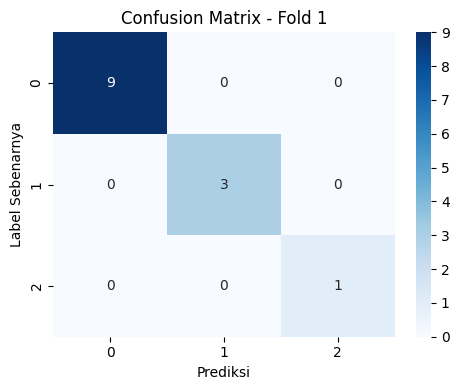


 Fold 2 Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00         2

    accuracy                           1.00        12
   macro avg       1.00      1.00      1.00        12
weighted avg       1.00      1.00      1.00        12



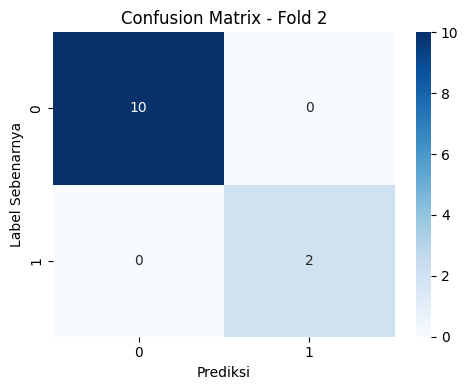


 Fold 3 Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         9
           1       1.00      1.00      1.00         2
          10       1.00      1.00      1.00         1

    accuracy                           1.00        12
   macro avg       1.00      1.00      1.00        12
weighted avg       1.00      1.00      1.00        12



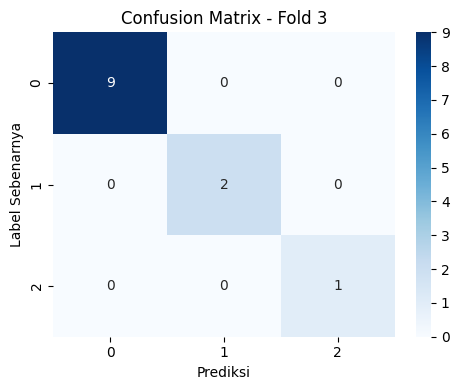


 Akurasi Rata-rata CV: 1.0000 ± 0.0000
Log hasil disimpan ke: svm_pso_log.csv


In [15]:
result = run_svm_pso_pipeline(features_df, n_particles=20, n_iter=50, cv=3, save_csv=True)
